In [1]:
import pandas as pd

In [3]:
import os
import glob

def get_all_csv_files(directory):
    # Join the directory path and the pattern for .csv files
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    
    return csv_files





In [ ]:

# Example usage:
directory_path = '../data/'
csv_files = get_all_csv_files(directory_path)
count = 0
total = len(csv_files)
marker = 10
for file in csv_files:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    data = pd.read_csv(file)
    data.dropna(inplace=True)
    data = data.reset_index()
    if not data.empty:
        index = data['DATE (YYYY-MM-DDTHH:MI:SSZ)'].unique()
        float_number = data['PLATFORM_CODE'].iloc[0]
        
        agg_data = {
            'float_number': []
            ,'date':[]
            ,'latitude':[]
            ,'longitude':[]
            ,'q0_psal':[]
            ,'q1_psal':[]
            ,'q2_psal':[]
            ,'q3_psal':[]
            ,'q4_psal':[]
            ,'q0_temp':[]
            ,'q1_temp':[]
            ,'q2_temp':[]
            ,'q3_temp':[]
            ,'q4_temp':[]
        }

        if 'PSAL (psu)' in data.columns and 'TEMP (degree_Celsius)' in data.columns:
            for i in index:
                subset = data[data['DATE (YYYY-MM-DDTHH:MI:SSZ)']==i]
                agg_data['float_number'].append(float_number)
                agg_data['date'].append(i)
                agg_data['latitude'].append(subset['LATITUDE (degree_north)'].iloc[0])
                agg_data['longitude'].append(subset['LONGITUDE (degree_east)'].iloc[0])
                q0 = min(subset['PRES (decibar)'])
                q1 = min(subset['PRES (decibar)'], key=lambda x:abs(x-500))
                q2 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1000))
                q3 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1500))
                q4 = max(subset['PRES (decibar)'])
                agg_data['q0_psal'].append(subset[subset['PRES (decibar)']==q0]['PSAL (psu)'].iloc[0])
                agg_data['q1_psal'].append(subset[subset['PRES (decibar)']==q1]['PSAL (psu)'].iloc[0])
                agg_data['q2_psal'].append(subset[subset['PRES (decibar)']==q2]['PSAL (psu)'].iloc[0])
                agg_data['q3_psal'].append(subset[subset['PRES (decibar)']==q3]['PSAL (psu)'].iloc[0])
                agg_data['q4_psal'].append(subset[subset['PRES (decibar)']==q4]['PSAL (psu)'].iloc[0])
                agg_data['q0_temp'].append(subset[subset['PRES (decibar)']==q0]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q1_temp'].append(subset[subset['PRES (decibar)']==q1]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q2_temp'].append(subset[subset['PRES (decibar)']==q2]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q3_temp'].append(subset[subset['PRES (decibar)']==q3]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q4_temp'].append(subset[subset['PRES (decibar)']==q4]['TEMP (degree_Celsius)'].iloc[0])
            agg_data = pd.DataFrame(agg_data)
            agg_data['date'] = pd.to_datetime(agg_data['date'])
            agg_data['date'] = agg_data['date'].dt.strftime('%Y-%m-%d') 
            
            all_data = pd.concat([agg_data, all_data])
            all_data.to_csv('all_ocean_data.csv', index=False)




In [2]:
import pandas as pd
all_data = pd.read_csv('all_ocean_data.csv')

In [3]:
pd.set_option('display.min_rows', 70)
pd.set_option('display.max_columns', None)

In [4]:
sorted_data = all_data.sort_values(['date','float_number'], ascending=[True, True])

In [5]:
undup = sorted_data.drop_duplicates()
undup.shape

(681519, 14)

In [ ]:
for date in undup['date'].unique():

    print(undup[undup['date']==date][['date', 'latitude','longitude']])

In [23]:
import datetime as dt
undup['date'] = pd.to_datetime(undup['date'])
undup = undup[undup['date'].dt.year==2006]

C:\Users\Jon\AppData\Local\Temp\ipykernel_39148\3366570401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undup['date'] = pd.to_datetime(undup['date'])


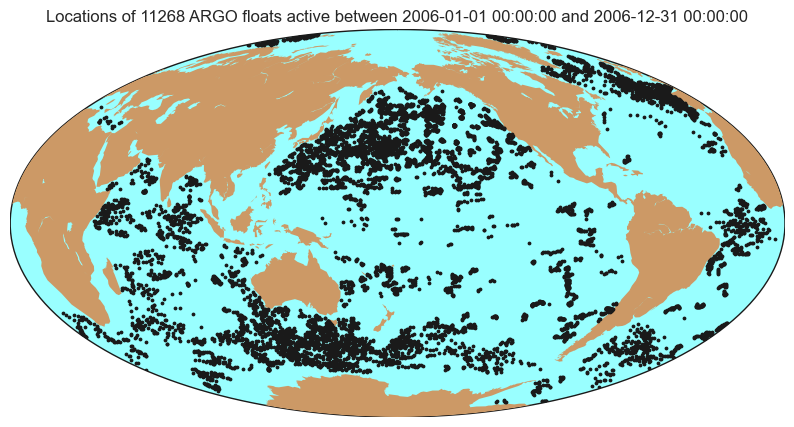

In [24]:
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
# data downloaded from the form at
# http://coastwatch.pfeg.noaa.gov/erddap/tabledap/apdrcArgoAll.html

lats = undup['latitude']
lons = undup['longitude']
time = undup['date']  # seconds since epoch
times = time
t1 = times.min(); t2 = times.max()
date1 = t1
date2 = t2

# draw map with markers for float locations
m = Basemap(projection='hammer',lon_0=180)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats active between %s and %s' %\
        (len(lats),date1,date2),fontsize=12)
plt.show()

## Making data for animated map

In [10]:
import pandas as pd
import numpy as np

def generate_interpolated_rows(df):
    # Sort the dataframe by 'id' and 'date' for each id
    df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is a datetime object
    df = df.sort_values(by=['float_number', 'date'])

    new_rows = []

    for idx in range(len(df) - 1):
        current_row = df.iloc[idx]
        next_row = df.iloc[idx + 1]

        # Check if it's the same 'id'
        if current_row['float_number'] == next_row['float_number']:
            # Calculate the number of days between the two dates
            days_diff = (next_row['date'] - current_row['date']).days
            
            if days_diff > 1:
                # Generate evenly spaced latitudes, longitudes, and dates
                latitudes = np.linspace(current_row['latitude'], next_row['latitude'], days_diff + 1)
                longitudes = np.linspace(current_row['longitude'], next_row['longitude'], days_diff + 1)
                dates = pd.date_range(current_row['date'], next_row['date'], periods=days_diff + 1)
                
                # Add the interpolated rows (excluding the first one because it's already in df)
                for i in range(1, days_diff):
                    new_row = {
                        'float_number': current_row['float_number'],
                        'latitude': latitudes[i],
                        'longitude': longitudes[i],
                        'date': dates[i]
                    }
                    new_rows.append(new_row)

    # Convert the new_rows list into a DataFrame and append to the original DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_rows_df]).sort_values(by=['float_number', 'date']).reset_index(drop=True)
    
    return df



In [7]:
all_ocean = pd.read_csv('all_ocean_data.csv')[['float_number','date','longitude','latitude']]

In [8]:
id_index = all_ocean['float_number']

In [13]:
all_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id_index[0]])
all_df.to_csv('data_for_map.csv', index=False)

C:\Users\Jon\AppData\Local\Temp\ipykernel_11384\1674890408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is a datetime object


In [ ]:
all

In [14]:
all_df = pd.read_csv('data_for_map.csv')

for id in id_index:
    new_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id])
    all_df = pd.concat([new_df, all_df])
    all_df.to_csv('data_for_map.csv', index=False)
    


C:\Users\Jon\AppData\Local\Temp\ipykernel_11384\1674890408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is a datetime object
